Feature Engineering for a Simple Decision Tree
==============================================

This notebook explores feature engineering along with a relatively simple decision tree model, to exceed the leaderboard performance of the existing gender submission file and get a 0.78708 score, in the top 20% of the leaderboard.

In [1]:
# import libraries and set constants
import pandas as pd
import numpy as np
import statistics as st

import sklearn.metrics as ms
import sklearn.tree as tr
import sklearn.preprocessing as pre
import sklearn.impute as imp
import sklearn.model_selection as mds

from scipy import interpolate
import matplotlib.pyplot as plt

DATA_DIR = f"../data/kaggle/"

In [2]:
df_train = pd.read_csv( DATA_DIR + "train.csv" )
df_test = pd.read_csv( DATA_DIR + "test.csv" )

# Feature Engineering

The model will perform better with some initial data preprocessing. This notebook starts with extracting the last name and the title from the name column. To ensure that our training set and our test set have the same features, we combine the two.

In [3]:
df_ = pd.concat([df_train, df_test])
print(df_.shape)

(1309, 12)


## Extract Title and Last Name

In [4]:
def split_last_name( row ):
    l_subs = row['Name'].split(r', ')
    return l_subs

def split_title( row ):
    l_subs = row[1].split(r'. ')
    if len(l_subs) > 2:
        l_subs[1] = f"{l_subs[1]} {l_subs[2]}"
        l_subs.pop()
    return l_subs

def get_other_titles( row ):

    l_titles = [ 'Mr', 'Mrs', 'Miss', 'Master' ]
    s_title = row['TitleGrp']

    if (not s_title in l_titles):
        if row['Sex'] == 'male':
            return 'OtherMale'
        else:
            return 'OtherFemale'
    else:
        return s_title

df_temp_name = df_.apply( split_last_name, axis=1, result_type='expand' )
df_temp_title = df_temp_name.apply( split_title, axis=1, result_type='expand' )

df_["LastName"] = df_temp_name[0]
df_["Title"] = df_temp_title[0]

df_['TitleGrp'] = df_['Title']
df_['TitleGrp'] = df_.apply( get_other_titles, axis=1 )

In [5]:
df_[["TitleGrp", "LastName", "Name"]].head(5).style.hide(axis="index")

TitleGrp,LastName,Name
Mr,Braund,"Braund, Mr. Owen Harris"
Mrs,Cumings,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)"
Miss,Heikkinen,"Heikkinen, Miss. Laina"
Mrs,Futrelle,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
Mr,Allen,"Allen, Mr. William Henry"


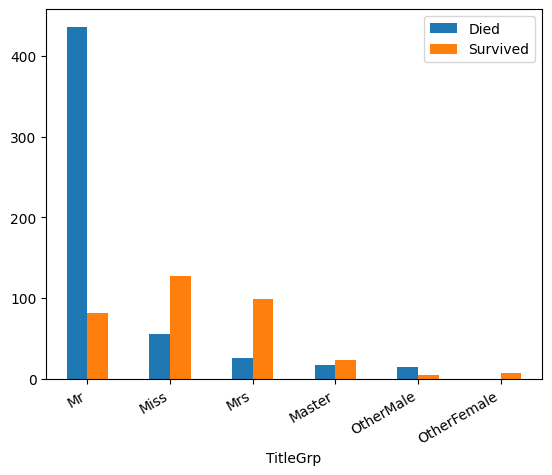

In [6]:
# transform the dataframe, so that it can be properly graphed as a bar plot
s_title_count = df_.groupby(["TitleGrp", "Survived"])["TitleGrp"].count()
df_title_survived = s_title_count.unstack("Survived")

# replace any n/a values with zeroes, and sort the bars by the number of people who died
df_title_survived.fillna(0)
df_title_survived.sort_values(by=0, inplace=True, ascending=False)

# plot the bar plot
df_title_survived.plot(kind='bar')
plt.legend(["Died", "Survived"])
plt.xticks(rotation=30, ha='right')
plt.show()

This model will combine the occurrence of the "Mr" title and the "OtherMale" title, since those seem to have similar survival rates. This feature will be binary (1 or 0) to make the Decision Tree model more clear.

In [7]:
df_["DeadTitle"] = df_["TitleGrp"].apply( 
    lambda v: 1 if (v=="Mr") or \
                   (v=="OtherMale") \
                else 0
)

## Passenger Class

Analysis shows that the passengers in third class had a much lower survival rate than the rest of the passengers. For the purposes of a binary decision tree, the model creates a binary feature of whether a passenger travels in the third class.

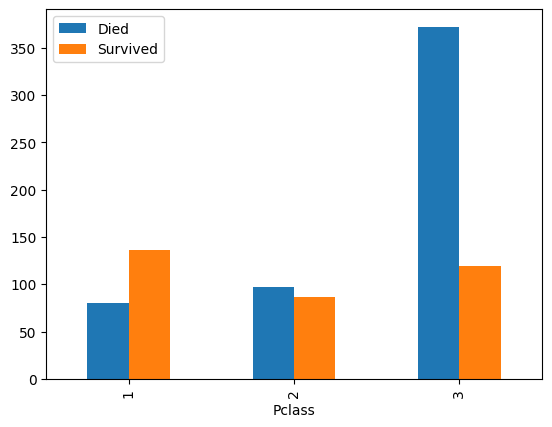

In [8]:
s_pclass_count = df_.groupby(["Pclass", "Survived"])["Pclass"].count()
df_pclass_survived = s_pclass_count.unstack("Survived")

df_pclass_survived.plot(kind='bar')

plt.legend(["Died", "Survived"])
plt.show()

In [9]:
df_["Pclass3"] = df_["Pclass"].apply( lambda v: 1 if v == 3 else 0 )
df_["Pclass2"] = df_["Pclass"].apply( lambda v: 1 if v == 2 else 0 )
df_["Pclass1"] = df_["Pclass"].apply( lambda v: 1 if v == 1 else 0 )

## Group Size / Ticket Frequency

In [10]:
def get_value_frequency(df, col_name):

    col_freq = df[[col_name]].value_counts()
    df_freq = col_freq.reset_index()

    freq_col_name = col_name + "Frequency"
    df_freq.columns = [col_name, freq_col_name]

    return df_freq

In [11]:
df_frequency = get_value_frequency( df_, "Ticket")
df_ = pd.merge(df_, df_frequency, how='left', on="Ticket")

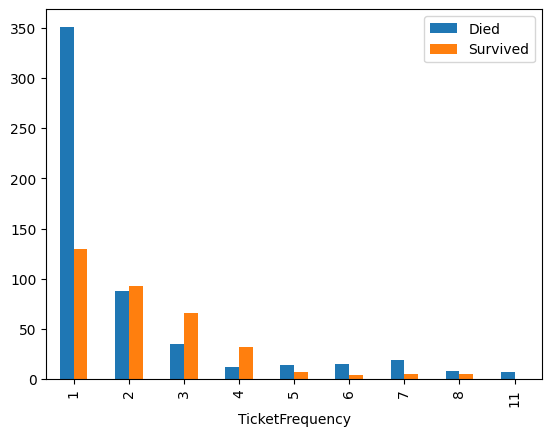

In [12]:
s_freq_count = df_.groupby(["TicketFrequency", "Survived"])["TicketFrequency"].count()
df_freq_survived = s_freq_count.unstack("Survived")

df_freq_survived.plot(kind='bar')

plt.legend(["Died", "Survived"])
plt.show()

Based on the graph above, there is clearly a difference in survival rates between 3 groups: 
solo travellers, small groups (2-4) and large groups (5 and above). With that in mind, we can set those 
three variables in our data set.

In [13]:
df_["Solo"] = df_["TicketFrequency"].apply( lambda v: 1 if v==1 else 0 )
df_["SmallGroup"] = df_["TicketFrequency"].apply( lambda v: 1 if (v<=4 and v>=2) else 0 )
df_["LargeGroup"] = df_["TicketFrequency"].apply( lambda v: 1 if (v>5) else 0 )

## Embark Location

In [14]:
def get_column_dummies( df, s_column ):

    df_temp = pd.DataFrame(df[["PassengerId", s_column ]])

    df_dummies = pd.get_dummies(df_temp[s_column])
    df_dummies["PassengerId"] = df_temp['PassengerId']
    df_dummies = df_dummies.map(lambda x: int(x))

    return df_dummies

In [15]:
# there are two missing Embarked values; since "S" is the most common, we'll fill them in with that
df_["Embarked"] = df_["Embarked"].fillna(value="S")

# one method 
df_embarked = get_column_dummies( df_, 'Embarked' )
for i in ["C", "Q", "S" ]:
    df_["Embark" + i ] = df_embarked[i]

enc = pre.OrdinalEncoder()
df_["EmbarkOrd"] = enc.fit_transform(df_[["Embarked"]])

In [16]:
df_[[ "LastName", "Pclass", "EmbarkOrd", "EmbarkC", "EmbarkQ", "EmbarkS" ]].head(6).style.hide(axis="index")

LastName,Pclass,EmbarkOrd,EmbarkC,EmbarkQ,EmbarkS
Braund,3,2.000000,0,0,1
Cumings,1,0.000000,1,0,0
Heikkinen,3,2.000000,0,0,1
Futrelle,1,2.000000,0,0,1
Allen,3,2.000000,0,0,1
Moran,3,1.000000,0,1,0


# Building the Decision Tree Model

## Split Train, Validate and Test Data

Given that this notebook combined test data with train data for feature engineering, those datasets need to be split apart again. Dividing the training and test sets is easy to do, as the test set contains "N/A" for the Survived column. 

In [17]:
df_train_clean = df_[ df_[ "Survived" ].notna() ].copy()

# prep the cleaned test data to write
df_test_clean = df_[ df_[ "Survived" ].isna() ].copy()
df_test_clean.drop( "Survived", axis=1, inplace=True )

print(f"Clean training data: {df_train_clean.shape}")
print(f"Clean test data:     {df_test_clean.shape}")

Clean training data: (891, 27)
Clean test data:     (418, 26)


Once the test set is broken out, then the model uses the sklearn library to further split the training data into a train dataset (X_train, y_train) and a validation (X_test, y_test) dataset.

In [18]:
x_colnames = [  "DeadTitle", "Pclass3","Pclass2", 
                "EmbarkS", "EmbarkQ", "EmbarkC", 
                "Solo", "SmallGroup", "LargeGroup" ]
y_colname  = [ "Survived" ]

X = df_train_clean[ x_colnames ]
y = df_train_clean[ y_colname ].values.ravel()

X_train, X_test, y_train, y_test = mds.train_test_split(X, y, test_size=0.2, random_state=42)

## Train the Model

In [19]:
# Create a decision tree classifier
dtc = tr.DecisionTreeClassifier( criterion='gini',
                                 max_depth         = 5,
                                 max_leaf_nodes    = 6,
                                 min_samples_split = 15,
                                 min_samples_leaf  = 10,
                                 random_state      = 42
                               )

# Train the classifier
model = dtc.fit(X_train, y_train)

## Visualize the Model

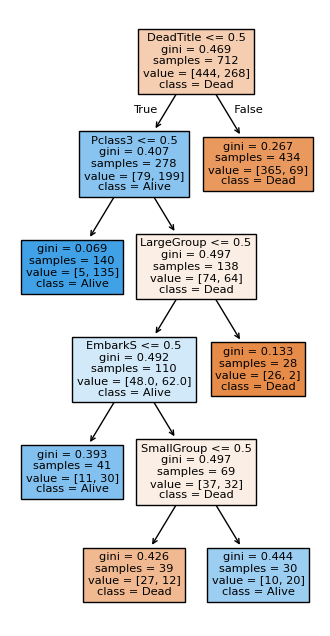

In [20]:
plt.figure(figsize=(4,8))
tr.plot_tree(model, feature_names=x_colnames, class_names=['Dead', 'Alive'], filled=True)
plt.show()

In [22]:
importances = model.feature_importances_
feature_imp_df = pd.DataFrame(
    {'Feature': x_colnames, 'Gini Importance': importances} ).sort_values(
         'Gini Importance', ascending=False)

feature_imp_df[ feature_imp_df[ 'Gini Importance' ] > 0 ].style.hide(axis="index")

Feature,Gini Importance
DeadTitle,0.661821
Pclass3,0.219293
LargeGroup,0.068107
SmallGroup,0.027522
EmbarkS,0.023256


# Analyzing Model Performance

There are a number of techniques available to analyze the performance of a model. This notebook uses a [Receiver Operating Characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) (ROC) curve, to measure the trade-off between the True-Positive Rate (tpr) and the False-Positive Rate (fpr). It charts a similar trade-off between between the Precision and Recall values.

From anecdotal testing and exploration, it seems that the Titanic test dataset favors false negatives over false postives, so when a threshold is found, we lean more towards a false negative than a false positive.

In [ ]:
def get_roc_curve_info( model, X, y ):

    y_preds_proba = model.predict_proba(X)

    fpr, tpr, thresh = ms.roc_curve(y, y_preds_proba[:,1])
    roc_auc = ms.auc(fpr, tpr)

    return roc_auc, fpr, tpr, thresh

In [ ]:
def get_gmeans_threshold( fpr, tpr, thresholds ):

    # Calculate the geometric mean
    gmeans = np.sqrt(tpr * (1 - fpr))
    
    # Locate the index of the largest gmean
    index = np.argmax(gmeans)

    return thresholds[index]

In [21]:
def get_operating_point( fpr, tpr, thresholds ):

    tpr_intrp = interpolate.interp1d(thresholds, tpr)
    fpr_intrp = interpolate.interp1d(thresholds, fpr)

    thresh = get_gmeans_threshold( fpr, tpr, thresholds)
    
    op_fpr = fpr_intrp(thresh).ravel()
    op_tpr = tpr_intrp(thresh).ravel()

    distances = (fpr - op_fpr)**2 + (tpr - op_tpr)**2
    closest_index = distances.argmin()
    op_thresh = thresholds[ closest_index ]

    return op_fpr, op_tpr, op_thresh

In [23]:
train_roc_auc, train_fpr, train_tpr, train_thresholds = get_roc_curve_info( model, X_train, y_train )
test_roc_auc, test_fpr, test_tpr, test_thresholds = get_roc_curve_info( model, X_test, y_test )

#test_threshold = get_gmeans_threshold( test_fpr, test_tpr, test_thresholds )
tt_fpr, tt_tpr, test_threshold = get_operating_point( test_fpr, test_tpr, test_thresholds )
print(f"Threshold: {round(test_threshold,3)} at fpr: {round(tt_fpr[0],3)}, tpr: {round(tt_tpr[0],3)}")

Threshold: 0.667 at fpr: 0.105, tpr: 0.73


## ROC Curve

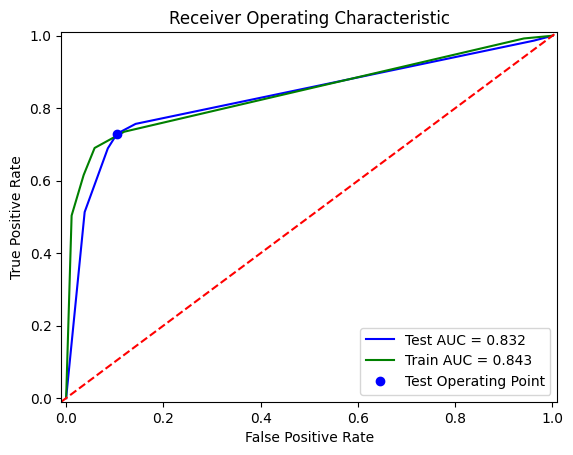

In [24]:
plt.title('Receiver Operating Characteristic')

min_lim = -0.01
max_lim = 1.01

plt.plot(test_fpr, test_tpr, 'b', label = 'Test AUC = %0.3f' % test_roc_auc)
plt.plot(train_fpr, train_tpr, 'g', label = 'Train AUC = %0.3f' % train_roc_auc)
plt.plot([min_lim, max_lim], [min_lim, max_lim],'r--')

plt.plot(tt_fpr, tt_tpr, 'bo', label=f'Test Operating Point')

plt.xlim([min_lim, max_lim])
plt.ylim([min_lim, max_lim])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc = 'lower right')
plt.show()

In [25]:
def print_confusion_matrix( y, y_preds, threshold ):

    tn, fp, fn, tp = ms.confusion_matrix(y, y_preds).ravel()
    print(f"Confusion Matrix, at Threshold {threshold:.3f}")
    print(f"  tn {tn:<3}  fp {fp:<3}")
    print(f"  fn {fn:<3}  tp {tp:<3}")
    print()

In [26]:
def print_validation_scores( y, y_preds ):

    bal_acc   = round( ms.balanced_accuracy_score( y, y_preds ), 3 )
    precision = round( ms.precision_score( y, y_preds ), 3 )
    recall    = round( ms.recall_score( y, y_preds ), 3 )
    f1        = round( ms.f1_score( y, y_preds, average='micro' ), 3 )

    s_scores = f"Bal Acc: {bal_acc}, Pre: {precision}, Rec: {recall}, F1 Micro: {f1}"
    print(s_scores)
    print()

    return bal_acc, precision, recall, f1

In [27]:
def print_kfold_scores( model, X, y ):

    s_scoring = "balanced_accuracy"
    n_folds = 5
    
    l_raw_scores = mds.cross_val_score(model, X_test, y_test, scoring=s_scoring, cv=n_folds)

    l_scores = [ round(i, 2) for i in l_raw_scores ]

    formatted_scores = [f"{num:.3f}" for num in l_scores]

    mean_score = round(st.mean(l_scores), 3)
    std_score = round(st.stdev(l_scores), 3)

    print(f"{n_folds}-fold {s_scoring} mean: {mean_score}, stdev: {std_score}")
    print(f"  each: {formatted_scores}")

In [28]:
y_test_preds_proba = model.predict_proba(X_test)
y_test_preds = (y_test_preds_proba[:,1] > test_threshold).astype(int)

print_confusion_matrix( y_test, y_test_preds, test_threshold )
bal, pre, rec, f1 = print_validation_scores( y_test, y_test_preds )
print_kfold_scores( model, X, y )

Confusion Matrix, at Threshold 0.667
  tn 96   fp 9  
  fn 23   tp 51 

Bal Acc: 0.802, Pre: 0.85, Rec: 0.689, F1 Micro: 0.821

5-fold balanced_accuracy mean: 0.778, stdev: 0.068
  each: ['0.750', '0.890', '0.760', '0.780', '0.710']


## Precision-Recall Curve

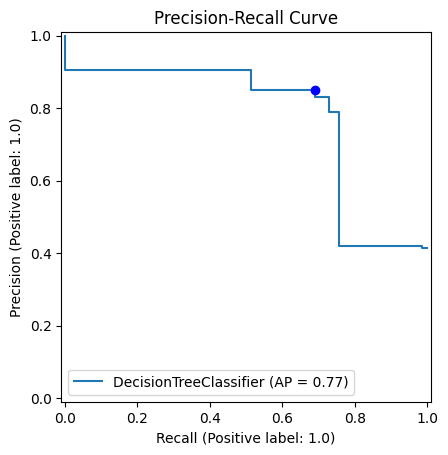

In [29]:
# Plot the precision-recall curve
display = ms.PrecisionRecallDisplay.from_estimator(model, X_test, y_test)
plt.title('Precision-Recall Curve')
plt.plot(rec, pre, 'bo', label=f'Test Operating Point')
plt.show()

In [30]:
df_validate_set = pd.DataFrame(index=X_test.index)
df_validate_set["Prob"] = y_test_preds_proba[:,1]
df_validate_set["Predict"] = y_test_preds

df_merged = pd.merge(df_train_clean, df_validate_set, left_index=True, right_index=True)
df_sort = df_merged.sort_values( by="Prob", ascending=True )

num_display_rows = 10
sample_size = 5
display_columns = [ "Survived", "Predict", "Prob", "Pclass", "Title", "LastName", "Age", "Embarked", "Ticket", "TicketFrequency" ]

## Predicted Deaths

In [31]:
df_sort[ df_sort["Prob"] <= test_threshold ][ display_columns ].tail(num_display_rows) \
    .sample(n=sample_size).sort_values(by="Prob", ascending=True)

,Survived,Predict,Prob,Pclass,Title,LastName,Age,Embarked,Ticket,TicketFrequency
396,0.0,0,0.307692,3,Miss,Olsson,31.0,S,350407,1
192,1.0,0,0.307692,3,Miss,Andersen-Jensen,19.0,S,350046,1
777,1.0,0,0.666667,3,Miss,Emanuel,5.0,S,364516,2
49,0.0,0,0.666667,3,Mrs,Arnold-Franchi,18.0,S,349237,2
254,0.0,0,0.666667,3,Mrs,Rosblom,41.0,S,370129,3


## Predicted Survivors

In [32]:
df_sort[ df_sort["Prob"] > test_threshold ][ display_columns ].head(num_display_rows) \
    .sample(n=sample_size).sort_values(by="Prob", ascending=True)

,Survived,Predict,Prob,Pclass,Title,LastName,Age,Embarked,Ticket,TicketFrequency
830,1.0,1,0.731707,3,Mrs,Yasbeck,15.0,C,2659,2
767,0.0,1,0.731707,3,Miss,Mangan,30.5,Q,364850,1
359,1.0,1,0.731707,3,Miss,Mockler,NaN,Q,330980,1
300,1.0,1,0.731707,3,Miss,Kelly,NaN,Q,9234,1
82,1.0,1,0.731707,3,Miss,McDermott,NaN,Q,330932,1


# Creating the Submission File

In [33]:
y_proba = model.predict_proba(df_test_clean[x_colnames])
y_preds = (y_proba[:,1] > test_threshold).astype(int)

df_test_clean["Prob"] = y_proba[:,1]
df_test_clean["Survived"] = y_preds

df_test_clean[["PassengerId", "Survived"]].to_csv(DATA_DIR + f"submission.csv", index=False)